In [1]:
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
from time import time

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
data = torch.load('../data.pt')

for dataset in data:
    data[dataset] = data[dataset].float()

In [3]:
from lib.Signature import Signature, Basepoint, sig_lreg, Cumsum2
from lib.Utilities import get_n_params
from lib.NSDE import SigNSDE

In [4]:
hp = {'nsamples_fs': 100, 'batch_size': 64}

In [5]:
data_size = 1
cvector_size = 84
initial_noise_size = 16
hidden_size = 92
architectures = {'initial': [32], 'drift': [32, 32, 32, 32, 32], 'diffusion': [32, 32, 32, 32, 32]}
t_norm=None
noise_size = 10
noise_type = 'general'
final_tanh = True
proj = False
translation = False

In [6]:
x_length = np.arange(2, 400, 20).tolist()
x_length_time = torch.zeros([len(x_length), 25])
x_length_memory = torch.zeros([len(x_length), 25])

In [7]:
for i in range(len(x_length)):
    
    x_length_ = x_length[i]
    data_ = {}
    for dataset in data:
        if dataset in ['X_train', 'X_val', 'X_test']:
            data_[dataset] = torch.clone(data[dataset][:, -x_length_:])
        else:
            data_[dataset] = torch.clone(data[dataset])
    
    print(data_['X_train'].shape)
    sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data_['X_train'].shape[2],
                  interval=[0, data_['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data_['X_train'][:, :, 0].max()).to(device)

    sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data_['Y_train'].shape[2],
                  interval=[0, data_['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data_['Y_train'][:, :, 0].max()).to(device)
    
    sig_size = sig_X(torch.zeros_like(data_['X_train'][:1])).shape[1]
    
    signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data_, 528, alpha=0.1, normalize_sig = True)
    
    
    
    G = SigNSDE(sig_size, data_size, cvector_size, initial_noise_size, hidden_size, architectures, t_norm, 
            noise_size, noise_type, final_tanh, proj, translation).to(device)
    
    G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)

    q = data_['Y_train'].shape[1]-1

    train_dataset = TensorDataset(signatures_X['train'], data_['X_train'][:, :, 1:], signatures_Y_pred['train'])
    train_dataloader = DataLoader(train_dataset, batch_size = hp['batch_size'], shuffle=True)
    infinite_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    trange = range(25)
    for step in trange:
        start_time = time()
        
        G_optimizer.zero_grad(set_to_none=True)
            
        sig_X_batch, X_batch, sigY_pred_batch = next(infinite_dataloader) 
        X_batch = X_batch[:, -1:, :]
        X_batch_mc = X_batch.repeat(hp['nsamples_fs'], 1, 1).requires_grad_().to(device, non_blocking=True)
        sig_X_batch_mc = sig_X_batch.repeat(hp['nsamples_fs'], 1).requires_grad_().to(device, non_blocking=True)
            
        del sig_X_batch, X_batch
    
        Y_batch_pred = G(sig_X_batch_mc, X_batch_mc, q)
        del X_batch_mc, sig_X_batch_mc      
        t = torch.arange(0, Y_batch_pred.shape[1]).repeat(Y_batch_pred.shape[0]).view(Y_batch_pred.shape[0], 
                                                                                                  Y_batch_pred.shape[1], 1).to(device, non_blocking=True)
        Y_batch_pred_t = torch.cat([t, Y_batch_pred], dim=2)
    
        del Y_batch_pred, t
        sigY_pred_batch = sigY_pred_batch.to(device, non_blocking=True) 
            
        loss = torch.sum(torch.norm(torch.mean(sig_Y(Y_batch_pred_t).view(hp['nsamples_fs'], sigY_pred_batch.shape[0], sigY_pred_batch.shape[1]), dim=0)-sigY_pred_batch, p=2, dim=1))
        
        loss.backward()
        del Y_batch_pred_t
        del loss
        
        G_optimizer.step()
        G_optimizer.zero_grad(set_to_none=True)
        
        end_time = time()
        x_length_time[i, step] = end_time-start_time
        x_length_memory[i, step] = torch.cuda.max_memory_allocated(device='cuda')*1e-6
        torch.cuda.reset_max_memory_allocated(device='cuda')
    

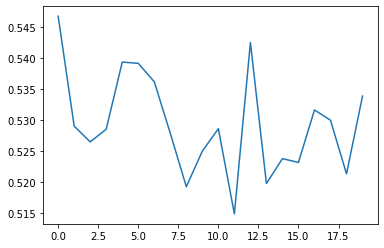

In [15]:
plt.plot(torch.mean(x_length_time, dim=1))

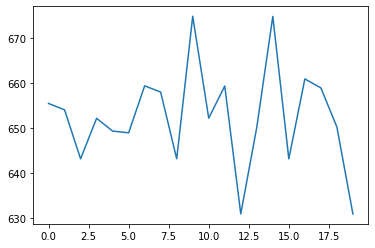

In [16]:
plt.plot(torch.mean(x_length_memory, dim=1))

In [17]:
torch.save(torch.mean(x_length_time, dim=1), 'x_length_time.pt')

In [18]:
torch.save(torch.mean(x_length_memory, dim=1), 'x_length_memory.pt')

In [19]:
sig_size = sig_X(torch.zeros_like(data['X_train'][:1])).shape[1]
data_size = 1
cvector_size = 32
initial_noise_size = 16
hidden_size = 48
architectures = {'initial': [32], 'drift': [84], 'diffusion': [84]}
t_norm=None
noise_size = 8
noise_type = 'diagonal'
final_tanh = True
proj = False
translation = False

In [20]:
x_length = np.arange(2, 400, 20).tolist()
x_length_time = torch.zeros([len(x_length), 25])
x_length_memory = torch.zeros([len(x_length), 25])

In [8]:
for i in range(len(x_length)):
    
    x_length_ = x_length[i]
    data_ = {}
    for dataset in data:
        if dataset in ['X_train', 'X_val', 'X_test']:
            data_[dataset] = torch.clone(data[dataset][:, -x_length_:])
        else:
            data_[dataset] = torch.clone(data[dataset])
    
    print(data_['X_train'].shape)
    sig_X = Signature(depth=5, augmentations = [Basepoint, Cumsum2], 
                  data_size=data_['X_train'].shape[2],
                  interval=[0, data_['X_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data_['X_train'][:, :, 0].max()).to(device)

    sig_Y = Signature(depth=4, augmentations = [Cumsum2], 
                  data_size=data_['Y_train'].shape[2],
                  interval=[0, data_['Y_train'].shape[1]+1], 
                  q=1, 
                  t_norm = data_['Y_train'][:, :, 0].max()).to(device)
    
    sig_size = sig_X(torch.zeros_like(data_['X_train'][:1])).shape[1]
    
    signatures_X, signatures_Y, signatures_Y_pred, sig_Y = sig_lreg(sig_X, sig_Y, data_, 528, alpha=0.1, normalize_sig = True)
    
    
    
    G = SigNSDE(sig_size, data_size, cvector_size, initial_noise_size, hidden_size, architectures, t_norm, 
            noise_size, noise_type, final_tanh, proj, translation).to(device)
    
    G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)

    q = data_['Y_train'].shape[1]-1

    train_dataset = TensorDataset(signatures_X['train'], data_['X_train'][:, :, 1:], signatures_Y_pred['train'])
    train_dataloader = DataLoader(train_dataset, batch_size = hp['batch_size'], shuffle=True)
    infinite_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    trange = tqdm(range(25))
    for step in trange:
        start_time = time()
        
        G_optimizer.zero_grad(set_to_none=True)
            
        sig_X_batch, X_batch, sigY_pred_batch = next(infinite_dataloader) # Get next batch of signatures of real path
        X_batch = X_batch[:, -1:, :]
        X_batch_mc = X_batch.repeat(hp['nsamples_fs'], 1, 1).requires_grad_().to(device, non_blocking=True)
        sig_X_batch_mc = sig_X_batch.repeat(hp['nsamples_fs'], 1).requires_grad_().to(device, non_blocking=True)
            
        del sig_X_batch, X_batch
    
        Y_batch_pred = G(sig_X_batch_mc, X_batch_mc, q)
        del X_batch_mc, sig_X_batch_mc      
        t = torch.arange(0, Y_batch_pred.shape[1]).repeat(Y_batch_pred.shape[0]).view(Y_batch_pred.shape[0], 
                                                                                                  Y_batch_pred.shape[1], 1).to(device, non_blocking=True)
        Y_batch_pred_t = torch.cat([t, Y_batch_pred], dim=2)
    
        del Y_batch_pred, t
        sigY_pred_batch = sigY_pred_batch.to(device, non_blocking=True) 
            
        loss = torch.sum(torch.norm(torch.mean(sig_Y(Y_batch_pred_t).view(hp['nsamples_fs'], sigY_pred_batch.shape[0], sigY_pred_batch.shape[1]), dim=0)-sigY_pred_batch, p=2, dim=1))
        
        loss.backward()
        del Y_batch_pred_t
        del loss
        
        G_optimizer.step()
        G_optimizer.zero_grad(set_to_none=True)
        
        end_time = time()
        x_length_time[i, step] = end_time-start_time
        x_length_memory[i, step] = torch.cuda.max_memory_allocated(device='cuda')*1e-6
        torch.cuda.reset_max_memory_allocated(device='cuda')
    

In [22]:
torch.save(torch.mean(x_length_time, dim=1), 'x_length_time_2.pt')
torch.save(torch.mean(x_length_memory, dim=1), 'x_length_memory_2.pt')